# Max 2-Sat

For the problem representation we used a standard format, widely accepted for boolean formulas in CNF, called [DIMACS](https://www.cs.utexas.edu/users/moore/acl2/manuals/current/manual/index-seo.php/SATLINK____DIMACS).

`usage` : change `PATH` variable, in the cell containing parameters, to choose the file of the problem you want to solve



In [21]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from neal import SimulatedAnnealingSampler

import numpy as np
import dwavebinarycsp
import dimod
import itertools 
import minorminer
import networkx as nx
import dwave_networkx as dnx

In [22]:
# parameters

TOKEN = 'DEV-2cc3acd9d7df48a4fcad58db19dc214c174b74e5' # API dwave
PATH = 'testing_sat/02-sat.txt' # current problem to solve
NUM_READS_SQA = 20
NUM_READS_QPU = 20
CHAIN_STRENGTH = 8

# Create QUBO

In order to create the QUBO of a MAX 2 SAT problem we followed [Glover 2019](https://arxiv.org/pdf/1811.11538.pdf). The formulas to convert traditional constraints into quadratic penalties can be found on page 15:


1. No negations: 
    Example $\left(x_{i} \vee x_{j}\right)$ 
    * Traditional constraint: $x_{i}+x_{j} \geq 1$ 
    * Quadratic Penalty: $\left(1-x_{i}-x_{j}+x_{i} x_{j}\right)$
2. One negation:
    Example $\left(x_{i} \vee \bar{x}_{j}\right)$
    * Traditional constraint: $x_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{j}-x_{i} x_{j}\right)$
3. Two negations: 
    Example $\left(\bar{x}_{i} \vee \bar{x}_{j}\right)$ 
    * Traditional constraint: $\bar{x}_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{i} x_{j}\right)$


In [23]:
# extract clauses and num of variables from the Max2-SAT problem specified in PATH

def extract_clauses(path):
    with open(path, "r") as f:
        # retrieve data from file
        sat = f.readlines()
        data = sat[0].split(" ")

    n_variables = int(data[2]) 

    sat = sat[1:]
    clauses = [x.replace(' 0\n', '') for x in sat]
    
    return clauses, n_variables

clauses, n_variables = extract_clauses(PATH) 
print(f'num_clauses {len(clauses)}')
print('-' * 30)  
print(f'num var {n_variables}')  
print('-' * 30)  
print(f'clauses {clauses}')  

num_clauses 12
------------------------------
num var 4
------------------------------
clauses ['1 2', '1 -2', '-1 2', '-1 -2', '-1 3', '-1 -3', '2 -3', '2 4', '-2 3', '-2 -3', '3 4', '-3 -4']


In [24]:
# generate the matrix Q, c and the graph of dependencies between all variables

def check_sparsity(q):
    count = 0
    tot = 0
    for x in q:
        for y in x:
            tot += 1
            if y == 0.:
                count += 1

    print(f'total dim is: {tot} elements that are zero: {count} sparsity: {count/tot}')

def gen_q(clauses, n_variables):
    
    Q = np.zeros(shape=(n_variables, n_variables))
    c = 0
    QUBO_graph = nx.Graph()
    for clause in clauses:
        clause = clause.split(' ')
        int_clause = [int(c) for c in clause]

        s1, s2 = int_clause[0], int_clause[1]
        v1, v2 = abs(s1)-1, abs(s2)-1
        QUBO_graph.add_edge(abs(s1), abs(s2))

        if s1 > 0 and s2 > 0: # True True
            # 1 - x1 - x2 + x1x2
            c += 1
            Q[v1][v1] += -1 
            Q[v2][v2] += -1
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2
        elif s1 > 0 and s2 < 0: # True False
            # x2 - x1x2
            Q[v2][v2] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 > 0: # False True
            # x1 - x1x2
            Q[v1][v1] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 < 0: # False False
            # x1x2
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2

        else:
            pass # throw error
            
    return Q, c, QUBO_graph

Q, c, QUBO_graph = gen_q(clauses, n_variables)

check_sparsity(Q)

print(f'Q is: \n{Q}')
print('-' * 40)
print(f'c is: {c}')

total dim is: 16 elements that are zero: 8 sparsity: 0.5
Q is: 
[[ 1.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.5]
 [ 0.  -0.5  0.   1. ]
 [ 0.   0.5  1.  -2. ]]
----------------------------------------
c is: 3


## Create BQM

In [25]:
# Create BQM
variable_order = ["x_{}".format(n) for n in range(1, n_variables+1)]
BQM = dimod.BinaryQuadraticModel.from_numpy_matrix(Q, variable_order = variable_order)
BQM

BinaryQuadraticModel({x_1: 1.0, x_2: 0.0, x_3: 0.0, x_4: -2.0}, {('x_2', 'x_3'): -1.0, ('x_2', 'x_4'): 1.0, ('x_3', 'x_4'): 2.0}, 0.0, 'BINARY')

# Solve

We now solve the problem through both simulated and real quantum annealing showing the results obtained.  

In [26]:
def print_response_data(response):
    # ------- Print results to user -------
    print('-' * 160)
    print('{:>40s}{:>40s}{:^40s}{:^40s}'.format('Set 0','Set 1','Energy',"Count"))
    print('-' * 160)
    for sample, E, occ in response.data(fields=['sample','energy',"num_occurrences"]):
        S0 = [k for k,v in sample.items() if v == 0]
        S1 = [k for k,v in sample.items() if v == 1]
        print('{:>40s}{:>40s}{:^40s}{:^40s}'.format(str(S0),str(S1),str(E),str(occ)))

## Simulated Quantum Annealing

In [27]:
def simulated_annealing(bqm):
    sampler = SimulatedAnnealingSampler()
    response_SQA = sampler.sample(bqm, num_reads=NUM_READS_SQA, chain_strength=CHAIN_STRENGTH)
    return response_SQA

## Real Quantum Annealing

In [28]:
def real_annealing(bqm):
    sampler = EmbeddingComposite(DWaveSampler(token=TOKEN))
    response_QPU = sampler.sample(bqm, num_reads=NUM_READS_QPU, chain_strength=CHAIN_STRENGTH)
    return response_QPU

# Results
In the result we select the most frequent solution and we show both the optimal number of unsatisfied constraints and the assignment of the optimal solution

In [29]:
# retrieve result with the best counts

def return_solution(response, Q, c):
    count = 0
    for i in range(len(response)):
        new_count = response[i][2]
        if  new_count > count:
            best = response[i][0]
            count = new_count
    
    y = c + np.matmul(np.matmul(best.T, Q), best) 

    return y, best

def print_solution(response, Q, c):
    y, best = return_solution(response.aggregate().record, Q, c)
    print(f'y is {int(y)} (optimal number of unsitisfied constraints)')

    for v in range(n_variables):
        print(f'x_{v+1} = {True if best[v] else False}')

def compare_simulation_real(resp_simulation, resp_real, Q, c):
    y_sim, best_sim = return_solution(resp_simulation.aggregate().record, Q, c)
    y_real, best_real = return_solution(resp_real.aggregate().record, Q, c)
    print(f'y simulation is {int(y_sim)}, y real is {int(y_real)} (optimal number of unsitisfied constraints)')

    sim_assignment = [best_sim[v] for v in range(n_variables)]
    real_assignment = [best_real[v] for v in range(n_variables)]

    count = 0
    for s, r in zip(sim_assignment, real_assignment):
        if r != s: 
            count += 1

    print(f'real and simulation assignment differ by: {count}')

## Simulated Quantum Annealing

In [30]:
response_SQA = simulated_annealing(BQM)

In [31]:
print_response_data(response_SQA.aggregate())

----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                   ['x_1', 'x_2', 'x_3']                                 ['x_4']                  -2.0                                     20                   


In [32]:
print_solution(response_SQA, Q, c)

y is 1 (optimal number of unsitisfied constraints)
x_1 = False
x_2 = False
x_3 = False
x_4 = True


## Real Quantum Annealing


In [33]:
response_QPU = real_annealing(BQM)

In [34]:
print_response_data(response_QPU)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                   ['x_1', 'x_2', 'x_3']                                 ['x_4']                  -2.0                                     20                   


In [35]:
print_solution(response_QPU, Q, c)

y is 1 (optimal number of unsitisfied constraints)
x_1 = False
x_2 = False
x_3 = False
x_4 = True


# Number of required Qubits

In [36]:
# identify the embedded graph on the architecture of the solver used in the real annealing

device = DWaveSampler(token=TOKEN)
device.solver.data['id']

QPU_graph = device.solver.data['properties']["couplers"]

embedded_graph = minorminer.find_embedding(QUBO_graph.edges(), QPU_graph)

embedded_graph

{1: [2500], 2: [4888], 3: [4873], 4: [2590]}

In [37]:
# print the number of qubit required in the embedding and the minimal and maximal length of the chains created

sublist = [values for keys, values in embedded_graph.items()]
flat_list = set(itertools.chain(*sublist))    

max_chain_length = None
min_chain_length = None

for _, chain in embedded_graph.items():
    if max_chain_length is None:
        max_chain_length = len(chain)
        min_chain_length = len(chain)

    if len(chain) > max_chain_length:
        max_chain_length = len(chain)

    if len(chain) < min_chain_length:
        min_chain_length = len(chain)

    
print("Embedding requires {} qubits and has chain lengths between {}-{}".format(len(flat_list),min_chain_length, max_chain_length))

Embedding requires 4 qubits and has chain lengths between 1-1


# Visualization

In [38]:
# solutions comparison
compare_simulation_real(response_SQA, response_QPU, Q, c)

y simulation is 1, y real is 1 (optimal number of unsitisfied constraints)
real and simulation assignment differ by: 0


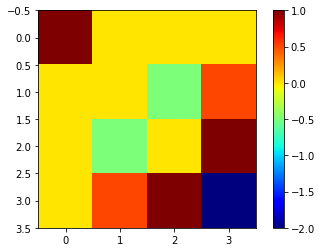

In [39]:
# plot the qubo matrix Q as a jet colormap

from matplotlib import pyplot as plt

plt.imshow(Q, cmap='jet')
plt.colorbar()

# Testing

In [20]:
# summary of all the time needed to execute the algorithm on the real quantum annealer

time_labels = [
'qpu_sampling_time', 
'qpu_anneal_time_per_sample', 
'qpu_readout_time_per_sample', 
'qpu_access_time', 
'qpu_access_overhead_time', 
'qpu_programming_time', 
'qpu_delay_time_per_sample', 
'total_post_processing_time', 
'post_processing_overhead_time'
]

total_time = 0
for t in time_labels:
    time = response_QPU.info["timing"][t]
    print(f'{t}: {time}μs')
    total_time += time
print(f'total time: {total_time}μs') 

qpu_sampling_time: 1587μs
qpu_anneal_time_per_sample: 20μs
qpu_readout_time_per_sample: 38μs
qpu_access_time: 17385μs
qpu_access_overhead_time: 18542μs
qpu_programming_time: 15797μs
qpu_delay_time_per_sample: 21μs
total_post_processing_time: 735μs
post_processing_overhead_time: 735μs
total time: 54860μs


# Benchmarks Report 
We tested our implementation with a total of 228 tests, with different number of variables and clauses. In particular we tested for:
- 120, 140, 160, 180, 200 variables
- 1200 to 2600 clauses

Benchmarks for the max2sat testing are taken from [here](http://maxsat.ia.udl.cat/benchmarks/)

results can be found [here](http://maxsat.ia.udl.cat/detailed/complete-ms-random-table.html)

we report them for simplicity: (we report only the best optimal result from the best solver for the benchmark)

| Label |                                            Meaning                                           |
|:-----:|:--------------------------------------------------------------------------------------------:|
| S     | Solution {OPTIMUM FOUND or OPT \| UNSATISFIABLE or UNSAT \| UNKNOWN \| Not available or N/A} |
| O     | Best solution found                                                                          |
| T     | CPU time (TO for Time Out)                                                                   |
| O_SA  | Solution of the simulated annealing                                                          |
| O_RA  | Solution of the real quantum annealing                                                       |
| Tp    | QPU programming time                                                                         |
| Ts    | QPU sampling time                                                                            |

Notes: 
- O, O_SA, O_RA denotes the optimal solution in term of non-satisfied clauses e.g. if we have 1000 clauses and the O or O_SA or O_RA are for instance 120 means that the assignment provided by the solution was able to satisfy 880 clauses.
- we reported here for simplicity only Tp (QPU programming time) and Ts (QPU sampling time) for the real quantum annealing, since were the ones with highest impact on the total time, for a detailed list of times per experiment check *Max2-Sat/testing_sat/Results/q_solutions.txt* 

    



Below the results for each benchmark, here we reported only QPU programming time and sampling time for simplicity.
For a detailed view on all the times for each experiment check q_solutions.txt file. The optimal time of the best classical solver (T)
is expressed in seconds, while the times of the results obtained with the quantum annealer are left in the same unit of measure
they are returned in the response, hence in microseconds.


| Benchmark | S | O | T | O_SA | O_RA | QPU programming time | QPU sampling time |
|:---------:|:-:|:-:|:-:|:----:|:----:|:--------------------:|:-----------------:|
|s2v120c1200-1.cnf|S=OPT | O=161 | T=5.65s | O_SA=324.0 | O_RA=312.0 | Tp=15805μs | Ts=2735μs |
|s2v120c1200-2.cnf|S=OPT | O=159 | T=8.40s | O_SA=299.0 | O_RA=289.0 | Tp=15816μs | Ts=3114μs |
|s2v120c1200-3.cnf|S=OPT | O=160 | T=2.70s | O_SA=294.0 | O_RA=290.0 | Tp=15794μs | Ts=2804μs |
|s2v120c1300-1.cnf|S=OPT | O=180 | T=14.94s | O_SA=355.0 | O_RA=325.0 | Tp=15800μs | Ts=3302μs |
|s2v120c1300-2.cnf|S=OPT | O=172 | T=6.29s | O_SA=312.0 | O_RA=305.0 | Tp=15794μs | Ts=2965μs |
|s2v120c1300-3.cnf|S=OPT | O=173 | T=5.96s | O_SA=334.0 | O_RA=307.0 | Tp=15812μs | Ts=2789μs |
|s2v120c1400-1.cnf|S=OPT | O=197 | T=17.17s | O_SA=374.0 | O_RA=368.0 | Tp=15806μs | Ts=3264μs |
|s2v120c1400-2.cnf|S=OPT | O=191 | T=10.06s | O_SA=349.0 | O_RA=338.0 | Tp=15814μs | Ts=2897μs |
|s2v120c1400-3.cnf|S=OPT | O=189 | T=8.30s | O_SA=378.0 | O_RA=381.0 | Tp=15812μs | Ts=3315μs |
|s2v120c1500-1.cnf|S=OPT | O=211 | T=8.00s | O_SA=390.0 | O_RA=401.0 | Tp=15799μs | Ts=3196μs |
|s2v120c1500-2.cnf|S=OPT | O=213 | T=27.02s | O_SA=370.0 | O_RA=390.0 | Tp=15807μs | Ts=3180μs |
|s2v120c1500-3.cnf|S=OPT | O=207 | T=6.18s | O_SA=378.0 | O_RA=394.0 | Tp=15807μs | Ts=3257μs |
|s2v120c1600-1.cnf|S=OPT | O=233 | T=24.19s | O_SA=427.0 | O_RA=408.0 | Tp=15798μs | Ts=2952μs |
|s2v120c1600-2.cnf|S=OPT | O=239 | T=85.74s | O_SA=389.0 | O_RA=402.0 | Tp=15798μs | Ts=2942μs |
|s2v120c1600-3.cnf|S=OPT | O=233 | T=29.73s | O_SA=403.0 | O_RA=405.0 | Tp=15789μs | Ts=3070μs |
|s2v120c1700-1.cnf|S=OPT | O=257 | T=51.12s | O_SA=431.0 | O_RA=459.0 | Tp=15809μs | Ts=3087μs |
|s2v120c1700-2.cnf|S=OPT | O=248 | T=66.38s | O_SA=421.0 | O_RA=406.0 | Tp=15803μs | Ts=2885μs |
|s2v120c1700-3.cnf|S=OPT | O=239 | T=5.69s | O_SA=444.0 | O_RA=454.0 | Tp=15809μs | Ts=2938μs |
|s2v120c1800-1.cnf|S=OPT | O=291 | T=383.01s | O_SA=461.0 | O_RA=464.0 | Tp=15803μs | Ts=3350μs |
|s2v120c1800-2.cnf|S=OPT | O=262 | T=16.59s | O_SA=436.0 | O_RA=481.0 | Tp=15801μs | Ts=3235μs |
|s2v120c1800-3.cnf|S=OPT | O=279 | T=64.81s | O_SA=459.0 | O_RA=441.0 | Tp=15813μs | Ts=3142μs |
|s2v120c1900-1.cnf|S=OPT | O=293 | T=64.83s | O_SA=491.0 | O_RA=492.0 | Tp=15798μs | Ts=3266μs |
|s2v120c1900-2.cnf|S=OPT | O=296 | T=144.99s | O_SA=478.0 | O_RA=478.0 | Tp=15793μs | Ts=2829μs |
|s2v120c1900-3.cnf|S=OPT | O=294 | T=88.19s | O_SA=499.0 | O_RA=476.0 | Tp=15803μs | Ts=3018μs |
|s2v120c2000-1.cnf|S=OPT | O=307 | T=27.04s | O_SA=489.0 | O_RA=500.0 | Tp=15808μs | Ts=3050μs |
|s2v120c2000-2.cnf|S=OPT | O=321 | T=651.59s | O_SA=513.0 | O_RA=512.0 | Tp=15805μs | Ts=2842μs |
|s2v120c2000-3.cnf|S=OPT | O=307 | T=71.32s | O_SA=474.0 | O_RA=472.0 | Tp=15801μs | Ts=2940μs |
|s2v120c2100-1.cnf|S=OPT | O=336 | T=64.23s | O_SA=513.0 | O_RA=492.0 | Tp=15804μs | Ts=3279μs |
|s2v120c2100-2.cnf|S=OPT | O=336 | T=691.62s | O_SA=508.0 | O_RA=505.0 | Tp=15801μs | Ts=3241μs |
|s2v120c2100-3.cnf|S=OPT | O=332 | T=214.08s | O_SA=542.0 | O_RA=487.0 | Tp=15801μs | Ts=2821μs |
|s2v120c2200-1.cnf|S=OPT | O=358 | T=446.53s | O_SA=559.0 | O_RA=547.0 | Tp=15798μs | Ts=3378μs |
|s2v120c2200-2.cnf|S=OPT | O=371 | T=1530.60s | O_SA=532.0 | O_RA=560.0 | Tp=15801μs | Ts=3058μs |
|s2v120c2200-3.cnf|S=OPT | O=359 | T=336.23s | O_SA=561.0 | O_RA=573.0 | Tp=15794μs | Ts=2914μs |
|s2v120c2300-1.cnf|S=OPT | O=380 | T=384.48s | O_SA=550.0 | O_RA=554.0 | Tp=15825μs | Ts=3425μs |
|s2v120c2300-2.cnf|S=OPT | O=383 | T=599.46s | O_SA=570.0 | O_RA=569.0 | Tp=15786μs | Ts=3389μs |
|s2v120c2300-3.cnf|S=OPT | O=365 | T=80.14s | O_SA=554.0 | O_RA=519.0 | Tp=15810μs | Ts=3181μs |
|s2v120c2400-1.cnf|S=OPT | O=389 | T=154.85s | O_SA=617.0 | O_RA=596.0 | Tp=15801μs | Ts=2930μs |
|s2v120c2400-2.cnf|S=OPT | O=402 | T=958.04s | O_SA=596.0 | O_RA=596.0 | Tp=15806μs | Ts=3152μs |
|s2v120c2400-3.cnf|S=OPT | O=380 | T=41.53s | O_SA=624.0 | O_RA=606.0 | Tp=15805μs | Ts=3226μs |
|s2v120c2500-1.cnf|S=OPT | O=418 | T=256.04s | O_SA=605.0 | O_RA=606.0 | Tp=15806μs | Ts=3122μs |
|s2v120c2500-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=620.0 | O_RA=622.0 | Tp=15805μs | Ts=3315μs |
|s2v120c2500-3.cnf|S=OPT | O=425 | T=898.11s | O_SA=656.0 | O_RA=626.0 | Tp=15805μs | Ts=3404μs |
|s2v120c2600-1.cnf|S=OPT | O=439 | T=877.77s | O_SA=687.0 | O_RA=654.0 | Tp=15813μs | Ts=3390μs |
|s2v120c2600-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=620.0 | O_RA=643.0 | Tp=15817μs | Ts=3030μs |
|s2v120c2600-3.cnf|S=OPT | O=440 | T=447.94s | O_SA=618.0 | O_RA=643.0 | Tp=15805μs | Ts=3449μs |
|s2v140c1200-1.cnf|S=OPT | O=144 | T=6.48s | O_SA=302.0 | O_RA=269.0 | Tp=15804μs | Ts=3121μs |
|s2v140c1200-2.cnf|S=OPT | O=155 | T=156.32s | O_SA=329.0 | O_RA=308.0 | Tp=15819μs | Ts=3032μs |
|s2v140c1200-3.cnf|S=OPT | O=155 | T=17.66s | O_SA=274.0 | O_RA=282.0 | Tp=15809μs | Ts=3310μs |
|s2v140c1300-1.cnf|S=OPT | O=162 | T=23.75s | O_SA=314.0 | O_RA=308.0 | Tp=15801μs | Ts=3086μs |
|s2v140c1300-2.cnf|S=OPT | O=171 | T=109.37s | O_SA=326.0 | O_RA=344.0 | Tp=15804μs | Ts=2919μs |
|s2v140c1300-3.cnf|S=OPT | O=168 | T=30.82s | O_SA=309.0 | O_RA=334.0 | Tp=15791μs | Ts=3147μs |
|s2v140c1400-1.cnf|S=OPT | O=182 | T=46.33s | O_SA=333.0 | O_RA=353.0 | Tp=15795μs | Ts=2969μs |
|s2v140c1400-2.cnf|S=OPT | O=178 | T=24.86s | O_SA=316.0 | O_RA=358.0 | Tp=15809μs | Ts=3164μs |
|s2v140c1400-3.cnf|S=OPT | O=193 | T=144.40s | O_SA=329.0 | O_RA=333.0 | Tp=15814μs | Ts=3129μs |
|s2v140c1500-1.cnf|S=OPT | O=205 | T=145.96s | O_SA=354.0 | O_RA=382.0 | Tp=15800μs | Ts=3132μs |
|s2v140c1500-2.cnf|S=OPT | O=199 | T=129.94s | O_SA=354.0 | O_RA=364.0 | Tp=15797μs | Ts=3374μs |
|s2v140c1500-3.cnf|S=OPT | O=212 | T=450.64s | O_SA=352.0 | O_RA=392.0 | Tp=15810μs | Ts=3154μs |
|s2v140c1600-1.cnf|S=OPT | O=221 | T=99.13s | O_SA=348.0 | O_RA=375.0 | Tp=15799μs | Ts=3187μs |
|s2v140c1600-2.cnf|S=OPT | O=221 | T=160.58s | O_SA=379.0 | O_RA=400.0 | Tp=15801μs | Ts=3299μs |
|s2v140c1600-3.cnf|S=OPT | O=226 | T=246.25s | O_SA=385.0 | O_RA=374.0 | Tp=15807μs | Ts=2995μs |
|s2v140c1700-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=447.0 | O_RA=428.0 | Tp=15815μs | Ts=3052μs |
|s2v140c1700-2.cnf|S=OPT | O=242 | T=206.76s | O_SA=415.0 | O_RA=424.0 | Tp=15803μs | Ts=3092μs |
|s2v140c1700-3.cnf|S=OPT | O=236 | T=69.70s | O_SA=453.0 | O_RA=436.0 | Tp=15798μs | Ts=3102μs |
|s2v140c1800-1.cnf|S=OPT | O=254 | T=324.26s | O_SA=459.0 | O_RA=439.0 | Tp=15810μs | Ts=2982μs |
|s2v140c1800-2.cnf|S=OPT | O=257 | T=132.36s | O_SA=474.0 | O_RA=430.0 | Tp=15813μs | Ts=3433μs |
|s2v140c1800-3.cnf|S=OPT | O=255 | T=67.50s | O_SA=458.0 | O_RA=410.0 | Tp=15809μs | Ts=3317μs |
|s2v140c1900-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=464.0 | O_RA=469.0 | Tp=15797μs | Ts=3318μs |
|s2v140c1900-2.cnf|S=OPT | O=273 | T=53.78s | O_SA=467.0 | O_RA=466.0 | Tp=15791μs | Ts=3095μs |
|s2v140c1900-3.cnf|S=OPT | O=278 | T=268.61s | O_SA=486.0 | O_RA=457.0 | Tp=15807μs | Ts=3086μs |
|s2v140c2000-1.cnf|S=OPT | O=298 | T=535.22s | O_SA=451.0 | O_RA=474.0 | Tp=15813μs | Ts=3356μs |
|s2v140c2000-2.cnf|S=OPT | O=308 | T=1178.33s | O_SA=536.0 | O_RA=529.0 | Tp=15800μs | Ts=3098μs |
|s2v140c2000-3.cnf|S=OPT | O=296 | T=269.67s | O_SA=515.0 | O_RA=496.0 | Tp=15814μs | Ts=3050μs |
|s2v140c2100-1.cnf|S=OPT | O=293 | T=33.99s | O_SA=485.0 | O_RA=502.0 | Tp=15806μs | Ts=3406μs |
|s2v140c2100-2.cnf|S=OPT | O=310 | T=190.04s | O_SA=505.0 | O_RA=516.0 | Tp=15787μs | Ts=3150μs |
|s2v140c2100-3.cnf|S=OPT | O=319 | T=593.53s | O_SA=511.0 | O_RA=545.0 | Tp=15812μs | Ts=3021μs |
|s2v140c2200-1.cnf|S=OPT | O=336 | T=1014.50s | O_SA=571.0 | O_RA=549.0 | Tp=15793μs | Ts=3084μs |
|s2v140c2200-2.cnf|S=OPT | O=332 | T=952.96s | O_SA=537.0 | O_RA=528.0 | Tp=15803μs | Ts=3334μs |
|s2v140c2200-3.cnf|S=OPT | O=329 | T=397.21s | O_SA=562.0 | O_RA=574.0 | Tp=15795μs | Ts=3178μs |
|s2v140c2300-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=574.0 | O_RA=558.0 | Tp=15793μs | Ts=3407μs |
|s2v140c2300-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=581.0 | O_RA=553.0 | Tp=15802μs | Ts=3295μs |
|s2v140c2300-3.cnf|S=OPT | O=352 | T=880.10s | O_SA=557.0 | O_RA=564.0 | Tp=15781μs | Ts=3250μs |
|s2v140c2400-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=586.0 | O_RA=617.0 | Tp=15807μs | Ts=3111μs |
|s2v140c2400-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=596.0 | O_RA=601.0 | Tp=15790μs | Ts=3292μs |
|s2v140c2400-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=599.0 | O_RA=592.0 | Tp=15798μs | Ts=3250μs |
|s2v140c2500-1.cnf|S=OPT | O=393 | T=837.06s | O_SA=588.0 | O_RA=586.0 | Tp=15799μs | Ts=3362μs |
|s2v140c2500-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=638.0 | O_RA=616.0 | Tp=15809μs | Ts=3399μs |
|s2v140c2500-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=590.0 | O_RA=625.0 | Tp=15806μs | Ts=3038μs |
|s2v140c2600-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=688.0 | O_RA=644.0 | Tp=15805μs | Ts=3347μs |
|s2v140c2600-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=652.0 | O_RA=630.0 | Tp=15805μs | Ts=3157μs |
|s2v140c2600-3.cnf|S=OPT | O=406 | T=961.82s | O_SA=644.0 | O_RA=661.0 | Tp=15816μs | Ts=3406μs |
|s2v160c1200-1.cnf|S=OPT | O=142 | T=43.42s | O_SA=294.0 | O_RA=309.0 | Tp=15821μs | Ts=3213μs |
|s2v160c1200-2.cnf|S=OPT | O=133 | T=8.96s | O_SA=322.0 | O_RA=309.0 | Tp=15798μs | Ts=3064μs |
|s2v160c1200-3.cnf|S=OPT | O=143 | T=86.49s | O_SA=296.0 | O_RA=307.0 | Tp=15797μs | Ts=3140μs |
|s2v160c1300-1.cnf|S=OPT | O=167 | T=337.15s | O_SA=317.0 | O_RA=328.0 | Tp=15799μs | Ts=3103μs |
|s2v160c1300-2.cnf|S=OPT | O=139 | T=2.90s | O_SA=319.0 | O_RA=338.0 | Tp=15815μs | Ts=3236μs |
|s2v160c1300-3.cnf|S=OPT | O=157 | T=86.01s | O_SA=303.0 | O_RA=329.0 | Tp=15797μs | Ts=3166μs |
|s2v160c1400-1.cnf|S=OPT | O=166 | T=36.36s | O_SA=358.0 | O_RA=382.0 | Tp=15803μs | Ts=3102μs |
|s2v160c1400-2.cnf|S=OPT | O=164 | T=38.99s | O_SA=333.0 | O_RA=365.0 | Tp=15810μs | Ts=3151μs |
|s2v160c1400-3.cnf|S=OPT | O=167 | T=21.86s | O_SA=350.0 | O_RA=379.0 | Tp=15795μs | Ts=3052μs |
|s2v160c1500-1.cnf|S=OPT | O=183 | T=14.22s | O_SA=396.0 | O_RA=383.0 | Tp=15807μs | Ts=3272μs |
|s2v160c1500-2.cnf|S=OPT | O=200 | T=905.90s | O_SA=369.0 | O_RA=365.0 | Tp=15793μs | Ts=3268μs |
|s2v160c1500-3.cnf|S=OPT | O=184 | T=62.16s | O_SA=389.0 | O_RA=373.0 | Tp=15807μs | Ts=3120μs |
|s2v160c1600-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=405.0 | O_RA=419.0 | Tp=15797μs | Ts=3329μs |
|s2v160c1600-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=386.0 | O_RA=409.0 | Tp=15799μs | Ts=3222μs |
|s2v160c1600-3.cnf|S=OPT | O=213 | T=743.89s | O_SA=399.0 | O_RA=412.0 | Tp=15791μs | Ts=3271μs |
|s2v160c1700-1.cnf|S=OPT | O=226 | T=659.70s | O_SA=425.0 | O_RA=428.0 | Tp=15809μs | Ts=3225μs |
|s2v160c1700-2.cnf|S=OPT | O=230 | T=572.97s | O_SA=412.0 | O_RA=450.0 | Tp=15803μs | Ts=3370μs |
|s2v160c1700-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=435.0 | O_RA=456.0 | Tp=15803μs | Ts=3316μs |
|s2v160c1800-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=426.0 | O_RA=452.0 | Tp=15818μs | Ts=3258μs |
|s2v160c1800-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=440.0 | O_RA=430.0 | Tp=15805μs | Ts=3207μs |
|s2v160c1800-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=465.0 | O_RA=471.0 | Tp=15812μs | Ts=3209μs |
|s2v160c1900-1.cnf|S=OPT | O=261 | T=1241.31s | O_SA=459.0 | O_RA=465.0 | Tp=15806μs | Ts=3205μs |
|s2v160c1900-2.cnf|S=OPT | O=262 | T=1480.92s | O_SA=490.0 | O_RA=473.0 | Tp=15805μs | Ts=3330μs |
|s2v160c1900-3.cnf|S=OPT | O=264 | T=995.23s | O_SA=460.0 | O_RA=483.0 | Tp=15790μs | Ts=3404μs |
|s2v160c2000-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=510.0 | O_RA=491.0 | Tp=15795μs | Ts=3220μs |
|s2v160c2000-2.cnf|S=OPT | O=272 | T=92.52s | O_SA=526.0 | O_RA=520.0 | Tp=15800μs | Ts=3206μs |
|s2v160c2000-3.cnf|S=OPT | O=282 | T=790.73s | O_SA=561.0 | O_RA=540.0 | Tp=15794μs | Ts=3369μs |
|s2v160c2100-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=535.0 | O_RA=534.0 | Tp=15807μs | Ts=3482μs |
|s2v160c2100-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=531.0 | O_RA=546.0 | Tp=15807μs | Ts=3488μs |
|s2v160c2100-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=511.0 | O_RA=522.0 | Tp=15799μs | Ts=3381μs |
|s2v160c2200-1.cnf|S=OPT | O=310 | T=642.57s | O_SA=552.0 | O_RA=506.0 | Tp=15815μs | Ts=3433μs |
|s2v160c2200-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=550.0 | O_RA=529.0 | Tp=15816μs | Ts=3384μs |
|s2v160c2200-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=532.0 | O_RA=530.0 | Tp=15799μs | Ts=3399μs |
|s2v160c2300-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=572.0 | O_RA=569.0 | Tp=15801μs | Ts=3394μs |
|s2v160c2300-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=617.0 | O_RA=591.0 | Tp=15807μs | Ts=3350μs |
|s2v160c2300-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=576.0 | O_RA=561.0 | Tp=15812μs | Ts=3420μs |
|s2v160c2400-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=594.0 | O_RA=618.0 | Tp=15807μs | Ts=3397μs |
|s2v160c2400-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=596.0 | O_RA=568.0 | Tp=15805μs | Ts=3404μs |
|s2v160c2400-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=603.0 | O_RA=574.0 | Tp=15783μs | Ts=3433μs |
|s2v160c2500-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=624.0 | O_RA=626.0 | Tp=15803μs | Ts=3456μs |
|s2v160c2500-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=630.0 | O_RA=650.0 | Tp=15796μs | Ts=3459μs |
|s2v160c2500-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=621.0 | O_RA=631.0 | Tp=15804μs | Ts=3470μs |
|s2v160c2600-1.cnf|S=OPT | O=392 | T=1596.27s | O_SA=655.0 | O_RA=642.0 | Tp=15801μs | Ts=3337μs |
|s2v160c2600-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=627.0 | O_RA=679.0 | Tp=15809μs | Ts=3386μs |
|s2v160c2600-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=615.0 | O_RA=653.0 | Tp=15806μs | Ts=3470μs |
|s2v180c1200-1.cnf|S=OPT | O=134 | T=147.86s | O_SA=301.0 | O_RA=293.0 | Tp=15810μs | Ts=3125μs |
|s2v180c1200-2.cnf|S=OPT | O=130 | T=79.94s | O_SA=275.0 | O_RA=281.0 | Tp=15807μs | Ts=3342μs |
|s2v180c1200-3.cnf|S=OPT | O=131 | T=156.38s | O_SA=313.0 | O_RA=318.0 | Tp=15812μs | Ts=3162μs |
|s2v180c1200-4.cnf|S=OPT | O=128 | T=135.96s | O_SA=293.0 | O_RA=301.0 | Tp=15801μs | Ts=3236μs |
|s2v180c1300-1.cnf|S=OPT | O=153 | T=646.96s | O_SA=321.0 | O_RA=319.0 | Tp=15795μs | Ts=3242μs |
|s2v180c1300-2.cnf|S=OPT | O=138 | T=43.39s | O_SA=356.0 | O_RA=341.0 | Tp=15798μs | Ts=3200μs |
|s2v180c1300-3.cnf|S=OPT | O=150 | T=165.80s | O_SA=319.0 | O_RA=314.0 | Tp=15810μs | Ts=3266μs |
|s2v180c1300-4.cnf|S=OPT | O=149 | T=288.42s | O_SA=309.0 | O_RA=323.0 | Tp=15807μs | Ts=3189μs |
|s2v180c1400-1.cnf|S=OPT | O=165 | T=433.80s | O_SA=326.0 | O_RA=356.0 | Tp=15801μs | Ts=3372μs |
|s2v180c1400-2.cnf|S=OPT | O=165 | T=514.80s | O_SA=348.0 | O_RA=333.0 | Tp=15804μs | Ts=3241μs |
|s2v180c1400-3.cnf|S=OPT | O=156 | T=133.24s | O_SA=343.0 | O_RA=339.0 | Tp=15804μs | Ts=3316μs |
|s2v180c1400-4.cnf|S=OPT | O=160 | T=245.56s | O_SA=327.0 | O_RA=351.0 | Tp=15808μs | Ts=3211μs |
|s2v180c1500-1.cnf|S=OPT | O=184 | T=1633.85s | O_SA=379.0 | O_RA=389.0 | Tp=15807μs | Ts=3293μs |
|s2v180c1500-2.cnf|S=OPT | O=180 | T=1434.90s | O_SA=381.0 | O_RA=357.0 | Tp=15803μs | Ts=3266μs |
|s2v180c1500-3.cnf|S=OPT | O=179 | T=291.29s | O_SA=374.0 | O_RA=353.0 | Tp=15798μs | Ts=3342μs |
|s2v180c1500-4.cnf|S=OPT | O=181 | T=406.46s | O_SA=357.0 | O_RA=378.0 | Tp=15813μs | Ts=3197μs |
|s2v180c1600-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=401.0 | O_RA=382.0 | Tp=15812μs | Ts=3390μs |
|s2v180c1600-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=374.0 | O_RA=365.0 | Tp=15803μs | Ts=3331μs |
|s2v180c1600-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=406.0 | O_RA=413.0 | Tp=15797μs | Ts=3244μs |
|s2v180c1600-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=402.0 | O_RA=384.0 | Tp=15820μs | Ts=3231μs |
|s2v180c1700-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=410.0 | O_RA=392.0 | Tp=15803μs | Ts=3278μs |
|s2v180c1700-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=406.0 | O_RA=397.0 | Tp=15813μs | Ts=3412μs |
|s2v180c1700-3.cnf|S=OPT | O=209 | T=1066.08s | O_SA=435.0 | O_RA=460.0 | Tp=15809μs | Ts=3265μs |
|s2v180c1700-4.cnf|S=OPT | O=206 | T=266.32s | O_SA=421.0 | O_RA=409.0 | Tp=15807μs | Ts=3426μs |
|s2v180c1800-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=424.0 | O_RA=442.0 | Tp=15805μs | Ts=3412μs |
|s2v180c1800-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=454.0 | O_RA=423.0 | Tp=15806μs | Ts=3430μs |
|s2v180c1800-3.cnf|S=OPT | O=232 | T=1359.50s | O_SA=429.0 | O_RA=421.0 | Tp=15826μs | Ts=3382μs |
|s2v180c1800-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=444.0 | O_RA=422.0 | Tp=15805μs | Ts=3389μs |
|s2v180c1900-1.cnf|S=OPT | O=245 | T=657.85s | O_SA=439.0 | O_RA=465.0 | Tp=15799μs | Ts=3394μs |
|s2v180c1900-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=482.0 | O_RA=479.0 | Tp=15811μs | Ts=3398μs |
|s2v180c1900-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=494.0 | O_RA=442.0 | Tp=15809μs | Ts=3490μs |
|s2v180c1900-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=498.0 | O_RA=465.0 | Tp=15825μs | Ts=3455μs |
|s2v180c2000-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=455.0 | O_RA=466.0 | Tp=15806μs | Ts=3375μs |
|s2v180c2000-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=485.0 | O_RA=506.0 | Tp=15814μs | Ts=3481μs |
|s2v180c2000-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=488.0 | O_RA=462.0 | Tp=15793μs | Ts=3467μs |
|s2v180c2000-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=538.0 | O_RA=481.0 | Tp=15802μs | Ts=3482μs |
|s2v180c2100-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=506.0 | O_RA=521.0 | Tp=15811μs | Ts=3472μs |
|s2v180c2100-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=548.0 | O_RA=535.0 | Tp=15814μs | Ts=3490μs |
|s2v180c2100-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=549.0 | O_RA=540.0 | Tp=15799μs | Ts=3462μs |
|s2v180c2100-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=527.0 | O_RA=554.0 | Tp=15805μs | Ts=3433μs |
|s2v180c2200-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=552.0 | O_RA=552.0 | Tp=15785μs | Ts=3498μs |
|s2v180c2200-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=542.0 | O_RA=576.0 | Tp=15790μs | Ts=3457μs |
|s2v180c2200-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=570.0 | O_RA=562.0 | Tp=15800μs | Ts=3498μs |
|s2v180c2200-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=537.0 | O_RA=508.0 | Tp=15803μs | Ts=3474μs |
|s2v200c1200-1.cnf|S=OPT | O=118 | T=133.09s | O_SA=296.0 | O_RA=310.0 | Tp=15811μs | Ts=3204μs |
|s2v200c1200-2.cnf|S=OPT | O=127 | T=332.19s | O_SA=286.0 | O_RA=314.0 | Tp=15804μs | Ts=3216μs |
|s2v200c1200-3.cnf|S=OPT | O=125 | T=475.72s | O_SA=275.0 | O_RA=294.0 | Tp=15800μs | Ts=3227μs |
|s2v200c1200-4.cnf|S=OPT | O=115 | T=29.65s | O_SA=286.0 | O_RA=298.0 | Tp=15798μs | Ts=3209μs |
|s2v200c1200-5.cnf|S=OPT | O=117 | T=148.82s | O_SA=318.0 | O_RA=296.0 | Tp=15793μs | Ts=3297μs |
|s2v200c1200-6.cnf|S=OPT | O=127 | T=275.54s | O_SA=320.0 | O_RA=314.0 | Tp=15807μs | Ts=3247μs |
|s2v200c1200-7.cnf|S=OPT | O=112 | T=17.12s | O_SA=327.0 | O_RA=306.0 | Tp=15811μs | Ts=3216μs |
|s2v200c1300-1.cnf|S=OPT | O=144 | T=655.54s | O_SA=337.0 | O_RA=283.0 | Tp=15818μs | Ts=3196μs |
|s2v200c1300-2.cnf|S=OPT | O=143 | T=874.62s | O_SA=335.0 | O_RA=337.0 | Tp=15809μs | Ts=3302μs |
|s2v200c1300-3.cnf|S=OPT | O=121 | T=62.43s | O_SA=317.0 | O_RA=310.0 | Tp=15813μs | Ts=3219μs |
|s2v200c1300-4.cnf|S=OPT | O=139 | T=306.59s | O_SA=334.0 | O_RA=325.0 | Tp=15808μs | Ts=3399μs |
|s2v200c1300-5.cnf|S=OPT | O=142 | T=572.57s | O_SA=337.0 | O_RA=340.0 | Tp=15806μs | Ts=3426μs |
|s2v200c1300-6.cnf|S=OPT | O=134 | T=517.50s | O_SA=305.0 | O_RA=302.0 | Tp=15799μs | Ts=3291μs |
|s2v200c1300-7.cnf|S=OPT | O=128 | T=32.98s | O_SA=307.0 | O_RA=312.0 | Tp=15813μs | Ts=3275μs |
|s2v200c1400-1.cnf|S=OPT | O=156 | T=756.32s | O_SA=354.0 | O_RA=334.0 | Tp=15801μs | Ts=3342μs |
|s2v200c1400-2.cnf|S=OPT | O=147 | T=156.52s | O_SA=347.0 | O_RA=325.0 | Tp=15805μs | Ts=3471μs |
|s2v200c1400-3.cnf|S=OPT | O=150 | T=182.12s | O_SA=344.0 | O_RA=380.0 | Tp=15803μs | Ts=3449μs |
|s2v200c1400-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=341.0 | O_RA=357.0 | Tp=15799μs | Ts=3298μs |
|s2v200c1400-5.cnf|S=OPT | O=153 | T=342.49s | O_SA=376.0 | O_RA=364.0 | Tp=15802μs | Ts=3398μs |
|s2v200c1400-6.cnf|S=OPT | O=145 | T=115.08s | O_SA=344.0 | O_RA=335.0 | Tp=15812μs | Ts=3400μs |
|s2v200c1400-7.cnf|S=OPT | O=142 | T=135.26s | O_SA=340.0 | O_RA=352.0 | Tp=15821μs | Ts=3396μs |
|s2v200c1500-1.cnf|S=OPT | O=165 | T=177.97s | O_SA=370.0 | O_RA=363.0 | Tp=15807μs | Ts=3404μs |
|s2v200c1500-2.cnf|S=OPT | O=165 | T=388.23s | O_SA=378.0 | O_RA=373.0 | Tp=15805μs | Ts=3417μs |
|s2v200c1500-3.cnf|S=OPT | O=165 | T=759.47s | O_SA=344.0 | O_RA=358.0 | Tp=15807μs | Ts=3373μs |
|s2v200c1500-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=397.0 | O_RA=357.0 | Tp=15810μs | Ts=3331μs |
|s2v200c1500-5.cnf|S=N/A | O=N/A | T=TOs | O_SA=362.0 | O_RA=345.0 | Tp=15808μs | Ts=3438μs |
|s2v200c1500-6.cnf|S=N/A | O=N/A | T=TOs | O_SA=378.0 | O_RA=389.0 | Tp=15805μs | Ts=3464μs |
|s2v200c1500-7.cnf|S=N/A | O=N/A | T=TOs | O_SA=393.0 | O_RA=386.0 | Tp=15794μs | Ts=3470μs |
|s2v200c1600-1.cnf|S=N/A | O=N/A | T=TOs | O_SA=422.0 | O_RA=421.0 | Tp=15801μs | Ts=3446μs |
|s2v200c1600-2.cnf|S=OPT | O=178 | T=307.70s | O_SA=407.0 | O_RA=370.0 | Tp=15795μs | Ts=3414μs |
|s2v200c1600-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=381.0 | O_RA=378.0 | Tp=15807μs | Ts=3415μs |
|s2v200c1600-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=410.0 | O_RA=391.0 | Tp=15801μs | Ts=3382μs |
|s2v200c1600-5.cnf|S=N/A | O=N/A | T=TOs | O_SA=387.0 | O_RA=407.0 | Tp=15799μs | Ts=3420μs |
|s2v200c1600-6.cnf|S=N/A | O=N/A | T=TOs | O_SA=397.0 | O_RA=406.0 | Tp=15803μs | Ts=3490μs |
|s2v200c1600-7.cnf|S=N/A | O=N/A | T=TOs | O_SA=397.0 | O_RA=386.0 | Tp=15805μs | Ts=3464μs |
|s2v200c1700-1.cnf|S=OPT | O=193 | T=146.26s | O_SA=427.0 | O_RA=395.0 | Tp=15803μs | Ts=3433μs |
|s2v200c1700-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=407.0 | O_RA=409.0 | Tp=15809μs | Ts=3498μs |
|s2v200c1700-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=424.0 | O_RA=435.0 | Tp=15817μs | Ts=3417μs |
|s2v200c1700-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=438.0 | O_RA=422.0 | Tp=15815μs | Ts=3498μs |
|s2v200c1700-5.cnf|S=N/A | O=N/A | T=TOs | O_SA=407.0 | O_RA=427.0 | Tp=15804μs | Ts=3443μs |
|s2v200c1700-6.cnf|S=N/A | O=N/A | T=TOs | O_SA=402.0 | O_RA=415.0 | Tp=15800μs | Ts=3474μs |
|s2v200c1700-7.cnf|S=N/A | O=N/A | T=TOs | O_SA=432.0 | O_RA=439.0 | Tp=15823μs | Ts=3433μs |
|s2v200c1800-1.cnf|S=OPT | O=206 | T=383.34s | O_SA=481.0 | O_RA=463.0 | Tp=15815μs | Ts=3480μs |
|s2v200c1800-2.cnf|S=N/A | O=N/A | T=TOs | O_SA=486.0 | O_RA=471.0 | Tp=15802μs | Ts=3449μs |
|s2v200c1800-3.cnf|S=N/A | O=N/A | T=TOs | O_SA=478.0 | O_RA=479.0 | Tp=15817μs | Ts=3438μs |
|s2v200c1800-4.cnf|S=N/A | O=N/A | T=TOs | O_SA=450.0 | O_RA=457.0 | Tp=15809μs | Ts=3471μs |
|s2v200c1800-5.cnf|S=N/A | O=N/A | T=TOs | O_SA=469.0 | O_RA=488.0 | Tp=15810μs | Ts=3462μs |
|s2v200c1800-6.cnf|S=N/A | O=N/A | T=TOs | O_SA=433.0 | O_RA=479.0 | Tp=15807μs | Ts=3463μs |
|s2v200c1800-7.cnf|S=N/A | O=N/A | T=TOs | O_SA=424.0 | O_RA=449.0 | Tp=15809μs | Ts=3462μs |
